# 1. 圖解台鐵 資料日期(2005~2017)

### 資料來源:https://data.gov.tw/dataset/8792
### 台灣各火車站每日進出人員記錄

### 導入套件

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### 讀入資料
### 原始資料範例：

In [2]:
train = pd.read_csv('data/tw train people.csv')
train.head()

,BOARD_DATE,TKT_BEG,STOP_NAME,進站,出站
0,20050101,2,馬蘭,0,1
1,20050101,4,台東,1422,1273
2,20050101,6,山里,1,11
3,20050101,8,鹿野,61,58
4,20050101,9,瑞源,44,63


### 資料筆數102萬：

In [3]:
train.shape[0]

1021539

## 資料前處理：
#### 將日期設為DatatimeIndex
#### 加入其他資料 : 各站總進出人數(st_all), 各站增加人數(st_add), 以了解各站服務人數(忙碌程度), 利用火車離開或是來到這個城市的程度

In [4]:
train.columns = ['date', 'station_num', 'station_name', 'st_in', 'st_out'] # column 重新命名
train['station_name'] = train['station_name'].str.split(' ').str[0]
train.index = pd.to_datetime(train['date'], format='%Y%m%d') # 處理日期模式
train.eval('st_all = st_out + st_in', inplace=True)
train.eval('st_add = st_out - st_in', inplace=True)
train = train[['st_in', 'st_out', 'st_add', 'st_all', 'station_num', 'station_name']]

### 檢查資料有沒有錯誤 
#### 將每日各站的進出人數總和, 每日各站新增人數總和應該為0

In [5]:
traind = train.groupby(train.index).sum()
display(traind.head())
display(traind['st_add'].sum())
traind = traind['st_in'] #服務人次取進站人數即可

,st_in,st_out,st_add,st_all,station_num
date,,,,,
2005-01-01,382902,382902,0,765804,27615
2005-01-02,412908,412908,0,825816,27182
2005-01-03,298141,298141,0,596282,26810
2005-01-04,252051,252051,0,504102,27064
2005-01-05,263399,263399,0,526798,27026


0

### 結果為0 表示資料無誤  或是資料整理過???  太準沒有人逃票???

### Data範例：

In [6]:
train.head()

,st_in,st_out,st_add,st_all,station_num,station_name
date,,,,,,
2005-01-01,0,1,1,1,2,馬蘭
2005-01-01,1422,1273,-149,2695,4,台東
2005-01-01,1,11,10,12,6,山里
2005-01-01,61,58,-3,119,8,鹿野
2005-01-01,44,63,19,107,9,瑞源


## 將資料分成年分總和  來看看台灣鐵道的成長
#### 可以發現使用台鐵人數 持續成長到2014年開始穩定

Text(0.5, 0, 'Year')

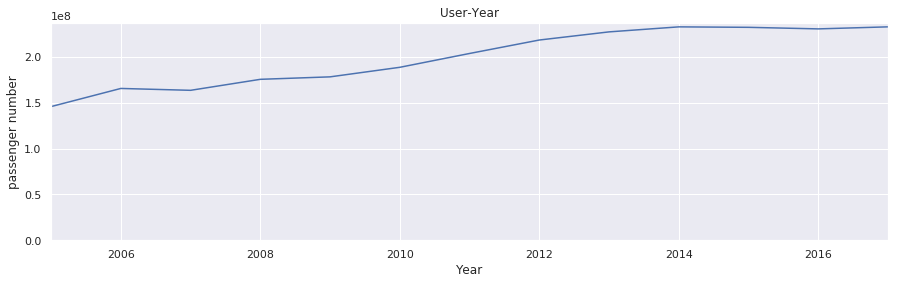

In [7]:
trainy = traind.groupby(traind.index.year).sum()
plt.figure(figsize=(15, 4))
trainy.plot()
plt.title('User-Year')
plt.ylim(0, )
plt.ylabel('passenger number')
plt.xlabel('Year')
#trainy

## 每個月的火車使用情況又是如何呢?
#### 可以看到圖形沒有太大的變化 表示每個月使用火車的人數相近

Text(0.5, 0, 'Month(2015~2017)')

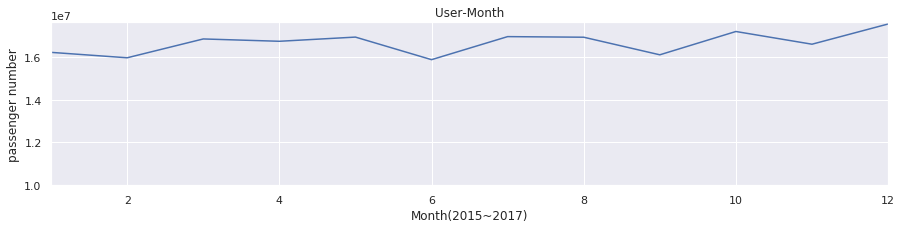

In [8]:
trainm = traind.groupby([traind.index.year, traind.index.month]).sum().unstack()
trainm = trainm.mean()
plt.figure(figsize=(15, 3))
trainm.plot()
plt.title('User-Month')
plt.ylim( 1e+07, )
plt.ylabel('passenger number')
plt.xlabel('Month(2015~2017)')
#trainm

## 一周的使用情況?
#### 週末 有明顯提高  周五和周日幾乎一樣(回家通勤)

Text(0.5, 0, 'Year(2015~2017)')

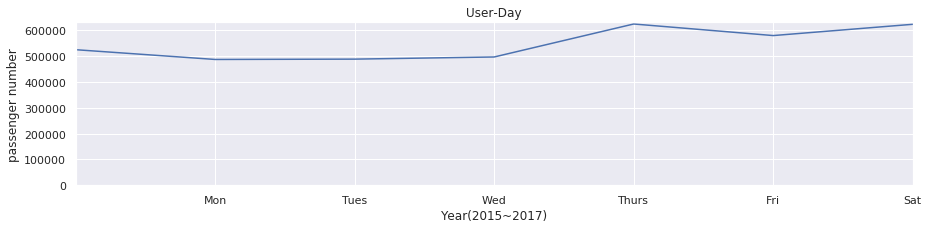

In [9]:
trainday = traind.groupby(traind.index.dayofweek).mean()
plt.figure(figsize=(15, 3))
trainday.plot()
plt.title('User-Day')
plt.ylim(0, )
plt.gca().set_xticklabels(['', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('passenger number')
plt.xlabel('Year(2015~2017)') 
#trainday

## 一年365天的使用情況?
### 有趣的是最高峰出現在跨年日  

Text(2012-12-31, 730000, "New Year's Day")

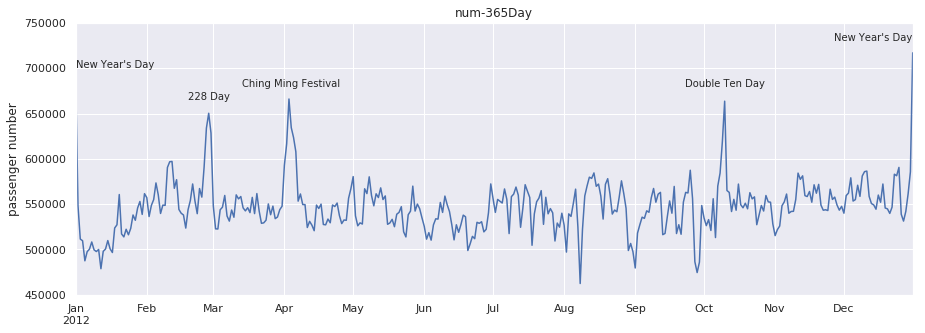

In [10]:
dayofyear = traind.groupby([traind.index.month,traind.index.day]).mean()
dayofyear.index = [pd.datetime(2012, month, day) for (month, day) in dayofyear.index]
fig = plt.figure(figsize=(15, 5))
dayofyear.plot()
plt.title('num-365Day')
plt.ylabel('passenger number')
plt.ylim(450000,750000)
plt.legend
plt.text('2012-1-1', 700000, "New Year's Day", ha='left')
plt.text('2012-2-28', 665000, "228 Day", ha='center')
plt.text('2012-4-4', 680000, "Ching Ming Festival", ha='center')
plt.text('2012-10-10', 680000, "Double Ten Day", ha='center')
plt.text('2012-12-31', 730000, "New Year's Day", ha='right')
#dayofyear.head()

### 每周有周期性高高低低 利用1周均日線讓圖形表現平滑
### 但是固定的日期都有預期的高峰: 228假期, 清明節, 國慶日

<function matplotlib.pyplot.legend(*args, **kwargs)>

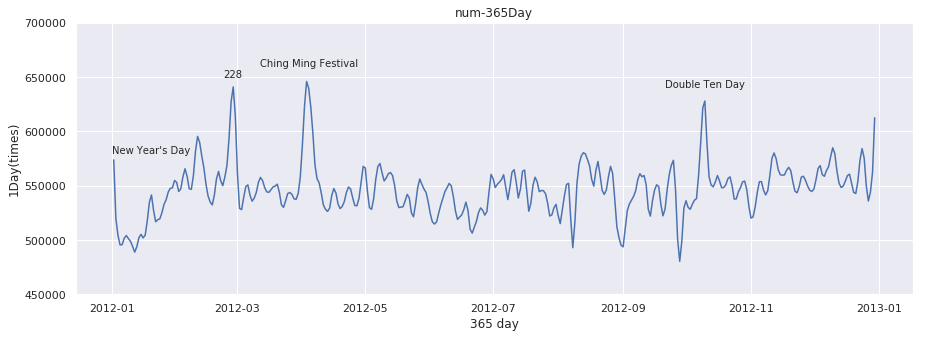

In [11]:
rolling = dayofyear.rolling(3, center=True, win_type='cosine')
data = rolling.mean()
fig = plt.figure(figsize=(15, 5))
plt.plot(data)
plt.title('num-365Day')
plt.ylabel('1Day(times)')
plt.ylim(450000,700000)
plt.text('2012-1-1', 580000, "New Year's Day", ha='left')
plt.text('2012-2-28', 650000, "228", ha='center')
plt.text('2012-4-4', 660000, "Ching Ming Festival", ha='center')
plt.text('2012-10-10', 640000, "Double Ten Day", ha='center')
plt.xlabel('365 day')
plt.legend

## 導入國曆農曆轉換

### 台灣很多連續假期都是過農曆年 在西曆上並不固定!!  在日期上要做國農曆轉換

In [12]:
lunar = pd.read_csv('data/AD-lunar.csv')
y_rem = pd.read_csv('data/y-rem.csv')
y_rem = y_rem.set_index('year')['month']
for n in range(6):
    yy = y_rem.index[n]
    mm = y_rem[y_rem.index[n]]
    lunar['lunM'] = lunar['lunM'] + (lunar['lunM'] == (mm + 1)).astype(int) * (13 - mm) * (lunar['lunY'] == yy).astype(int)
    lunar['lunM'] = lunar['lunM'] - (lunar['lunM'] > (mm + 1)).astype(int) * (lunar['lunY'] == yy).astype(int)
lunar.columns = ['date', 'lunar', 'lunY', 'lunM', 'lunD']
lunar.index = pd.to_datetime(lunar['date'])
lunar = lunar[['lunY', 'lunM', 'lunD']]
lunar = lunar.reset_index()
lunar = pd.merge(lunar, traind.reset_index())
lunar = lunar[['lunY', 'lunM', 'lunD', 'st_in']]
lunar = lunar.astype(int)
lunar = lunar.groupby(['lunM', 'lunD'])['st_in'].mean()
lunar = lunar.loc[(1,1):(12,31)]

### 除夕是最低點 表示除夕前大家都已經回家(但除夕前並沒有爆大量???)
### 最高峰是初二開始出遊, 端午和中秋節也沒有爆大量

<function matplotlib.pyplot.legend(*args, **kwargs)>

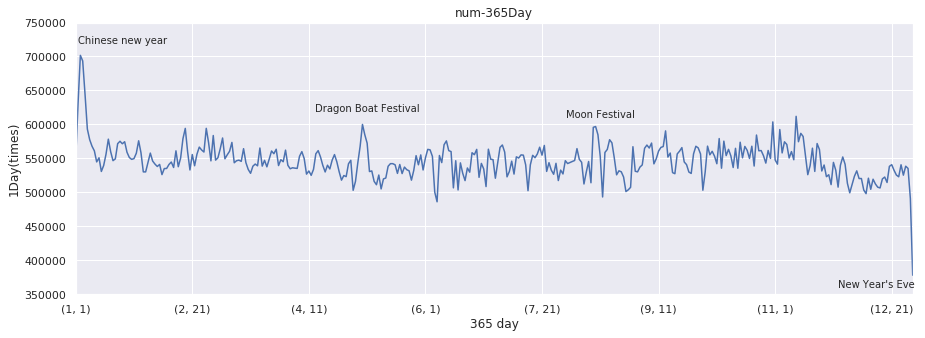

In [13]:
fig = plt.figure(figsize=(15, 5))
lunar.plot()
plt.title('num-365Day')
plt.ylabel('1Day(times)')
plt.xlabel('365 day')
plt.ylim(350000,750000)
plt.text(1, 720000, "Chinese new year")
plt.text(125, 620000, 'Dragon Boat Festival', ha='center')
plt.text(225, 610000, "Moon Festival", ha='center')
plt.text(360, 360000, "New Year's Eve", ha='right')
plt.legend

### 圖形圓化

<function matplotlib.pyplot.legend(*args, **kwargs)>

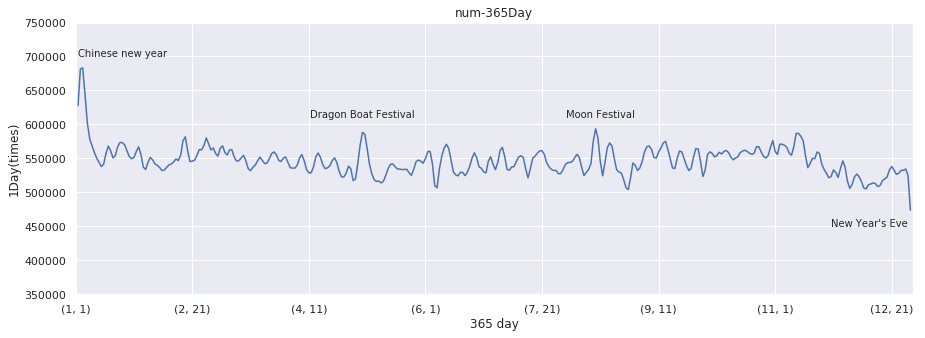

In [14]:
rolling = lunar.rolling(3, center=True, win_type='cosine')
data = rolling.mean()
fig = plt.figure(figsize=(15, 5))
data.plot()
plt.title('num-365Day')
plt.ylabel('1Day(times)')
plt.ylim(350000,750000)
plt.text(1, 700000, "Chinese new year")
plt.text(123, 610000, 'Dragon Boat Festival', ha='center')
plt.text(225, 610000, "Moon Festival", ha='center')
plt.text(357, 450000, "New Year's Eve", ha='right')
plt.xlabel('365 day')
plt.legend

## 台鐵現行車站討論

### 台鐵車站現行編號 : http://railway.hinet.net/Foreign/TW/stn-eng.html
### 合併現行車站資料 刪除一些舊站  或是車站更新

In [15]:
stnum = pd.read_csv('data/train st num gps.csv')
train = pd.merge(train.reset_index() ,stnum)
stnum = stnum.set_index('station_num')
stnum.head()

,station,latitude,longitude
station_num,,,
4,臺東,22.793716,121.120972
8,鹿野,22.912469,121.119494
9,瑞源,22.955998,121.156776
10,瑞和,22.979989,121.153650
12,關山,23.046184,121.162320


### 比較站名看是否有錯誤 錯誤的是"台" 和 "臺" 的關係(這樣無所謂 取其中一種就可以)

In [16]:
display(train[train['station'] != train['station_name']]['station'].value_counts())
train.index = pd.to_datetime(train['date'], format='%Y%m%d')
train = train[['st_in', 'st_out', 'st_add', 'st_all', 'station_num', 'station', 'latitude', 'longitude']]

臺南    4748
臺中    4748
臺北    4748
臺東    4748
Name: station, dtype: int64

### 加入的資料派上用場 來討論 各站總進出人數(st_all), 各站增加人數(st_add)

In [17]:
train_stadd = train.pivot_table('st_add' , index=train.index, columns='station_num')
train_stall = train.pivot_table('st_all' , index=train.index, columns='station_num')
train_stin = train.pivot_table('st_all' , index=train.index, columns='station_num')
train_stout = train.pivot_table('st_all' , index=train.index, columns='station_num')

## 編號100:台北
### 台北一年來來去去的平均人數
### 跨年夜 有大量的人湧入台北~ 然後在隔天離開  清明節則是先大量離開再回來!!

Text(0, 0.5, 'passenger add')

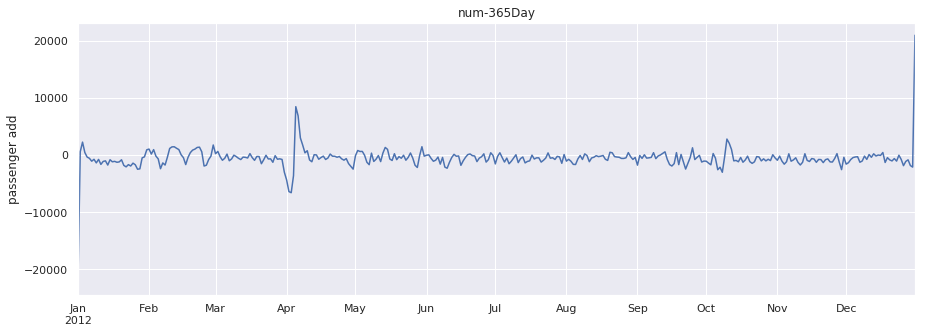

In [18]:
city_add = train_stadd[100].dropna()
city = city_add.groupby([city_add.index.month, city_add.index.day]).mean()
city.index = [pd.datetime(2012, month, day) for (month, day) in city.index]
fig = plt.figure(figsize=(15, 5))
city.plot()
plt.title('num-365Day')
plt.ylabel('passenger add')

## 與台北相反的城市 149 彰化
### 可以分析出居住的本地人分布

Text(0, 0.5, 'passenger add')

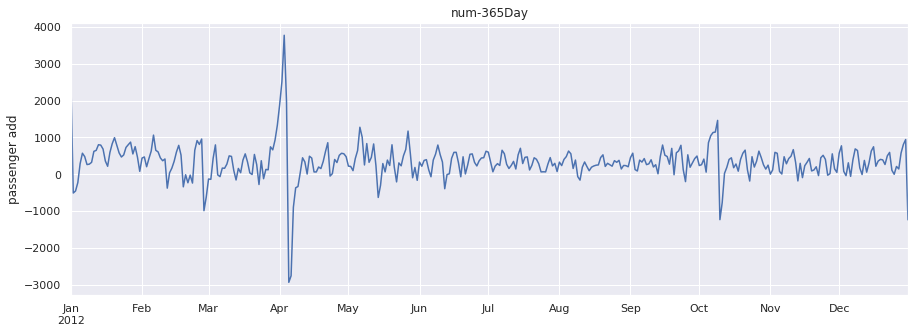

In [19]:
city_add = train_stadd[149].dropna()
city = city_add.groupby([city_add.index.month, city_add.index.day]).mean()
city.index = [pd.datetime(2012, month, day) for (month, day) in city.index]
fig = plt.figure(figsize=(15, 5))
city.plot()
plt.title('num-365Day')
plt.ylabel('passenger add')

### 同場加映：使用車站的熱點圖(使用GPS座標)

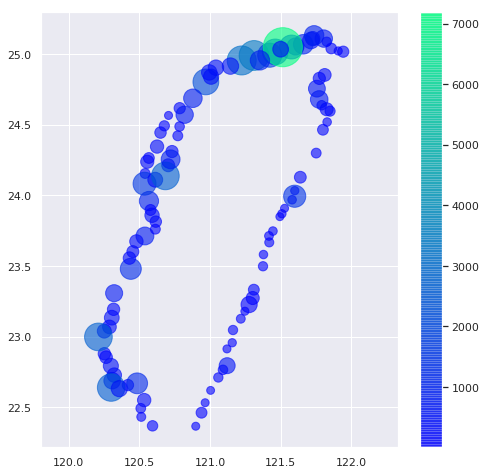

In [20]:
train2 = train.groupby(['station', 'latitude', 'longitude'])['st_all'].sum()
train2 = train2.reset_index().set_index('station')
x = train2['longitude']
y = train2['latitude']
s = train2['st_all']
s = s/s.min()
c = s
s = s/np.log(s)**2.5
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=c, s=s*50, alpha=0.6, cmap=plt.cm.winter)
plt.axis('equal')
plt.colorbar()

# 2. TW population 台灣人口圖解 資料日期 (106/12)

### 讀入資料'People107.csv'   原始資料範例：

In [21]:
pp = pd.read_csv('data/TW population_10612.csv')
pp.head()

,統計年月,區域別,村里,戶數,人口數,人口數-男,人口數-女,0歲-男,0歲-女,1歲-男,...,96歲-男,96歲-女,97歲-男,97歲-女,98歲-男,98歲-女,99歲-男,99歲-女,100歲以上-男,100歲以上-女
0,10612,新北市板橋區,留侯里,674,1645,775,870,9,3,8,...,0,0,0,0,0,0,0,0,0,1
1,10612,新北市板橋區,流芳里,640,1567,730,837,7,12,4,...,0,0,0,0,1,0,0,0,0,0
2,10612,新北市板橋區,赤松里,324,831,405,426,2,1,3,...,0,0,0,0,0,0,0,0,0,1
3,10612,新北市板橋區,黃石里,436,1147,568,579,3,4,10,...,0,0,0,1,0,0,0,0,1,0
4,10612,新北市板橋區,挹秀里,780,1884,904,980,3,5,4,...,1,1,0,0,2,0,0,0,0,0


## 資料處理:

In [22]:
pcol = list(pp.columns[7:])
pp['縣市'] = pp['區域別'].str[0:3]
pp['鄉鎮區'] = pp['區域別'].str[3:]
pp = pd.DataFrame(pp, columns=['縣市', '鄉鎮區', '村里'] + pcol)
pp = pp.set_index(['縣市', '鄉鎮區', '村里'])
pp.columns = pp.columns.str.split('歲').str[0]
pp = pp.T
pp.index = pp.index.astype(int)
pp.index.name = 'age'
pp['sex'] = ['M', 'F']*101
pp = pp.set_index(['sex', pp.index,])
pp = pp.sort_index()
pp = pp.unstack(level=0)
pp = pp.T

### 前8筆範例

In [23]:
pp.head(8)

age              0    1    2    3    4    5    6    7    8    9    ...  91   \
縣市  鄉鎮區 村里  sex                                                    ...        
新北市 板橋區 留侯里 F      3    6   10    3    6    9    6    7   10   10  ...    0   
            M      9    8    6    7    3   12    3    5   10    7  ...    0   
        流芳里 F     12    6    6   10    5    8    9    5    6    7  ...    1   
            M      7    4    5    7   10   12   12    6    7    9  ...    0   
        赤松里 F      1    4    1    8    3    8    6    5    2    4  ...    2   
            M      2    3    3    3    1    3    6    1    7    8  ...    1   
        黃石里 F      4    6    5   10    5    9   10    3    6    4  ...    2   
            M      3   10    3    4    5    5    8    3   13   14  ...    0   

age              92   93   94   95   96   97   98   99   100  
縣市  鄉鎮區 村里  sex                                               
新北市 板橋區 留侯里 F      0    2    1    0    0    0    0    0    1  
            M      0    0    2    0    0    0    0    0    0  
        流芳里 F      2    1    3    1    0    0    0    0    0  
            M      1    0    1    1    0    0    1    0    0  
        赤松里 F      1    0    0    0    0    0    0    0    1  
            M      1    0    0    0    0    0    0    0    0  
        黃石里 F      0    1    1    0    0    1    0    0    0  
            M      1    0    0    1    0    0    0    0    1  

[8 rows x 101 columns]

### 男女總人口數(年齡排序):

In [24]:
age = pp.groupby('sex').sum()
age

age,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
sex,,,,,,,,,,,,,,,,,,,,,
F,88352,101293,103890,103796,95348,114741,96743,81045,93650,95102,...,13272,10179,7566,5809,4577,3379,2238,1419,973,1805
M,95090,108888,112410,110720,102612,122946,104314,88178,101632,104081,...,11458,8856,6127,4431,3564,2619,1598,1080,724,1521


### 圖形:

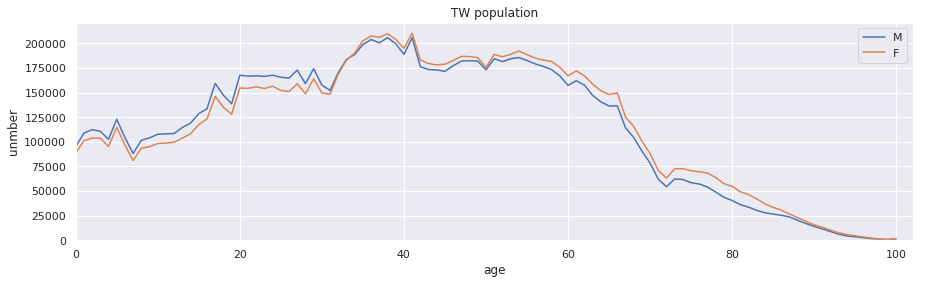

In [25]:
plt.figure(figsize=(15, 4))
plt.plot(age.values[1], label='M')
plt.plot(age.values[0], label='F')
plt.title('TW population')
plt.xlim(0, 102)
plt.ylim(0,)
plt.ylabel('unmber')
plt.xlabel('age')
plt.legend()

### 22縣市總人口比較:

In [26]:
city = pp.groupby('縣市').sum()
city.head()

age,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
縣市,,,,,,,,,,,,,,,,,,,,,
南投縣,3068,3443,3244,3228,2991,3828,3572,3193,3521,3685,...,665,472,319,264,194,158,77,57,45,57
嘉義市,1787,2229,2202,2298,2197,2810,2465,2181,2436,2652,...,292,206,166,106,89,69,30,27,18,36
嘉義縣,2684,2900,3024,2886,2781,3384,2995,2696,3187,3319,...,785,542,402,313,204,207,98,70,35,81
基隆市,2082,2456,2436,2252,2277,2875,2468,2259,2619,2718,...,431,344,208,190,158,89,58,35,39,87
宜蘭縣,3168,3532,3472,3506,3512,3989,3570,3180,3680,3636,...,581,414,280,212,178,106,82,54,36,73


### 比較三都(台北市TPE  新北市TPH  高雄市KHH)

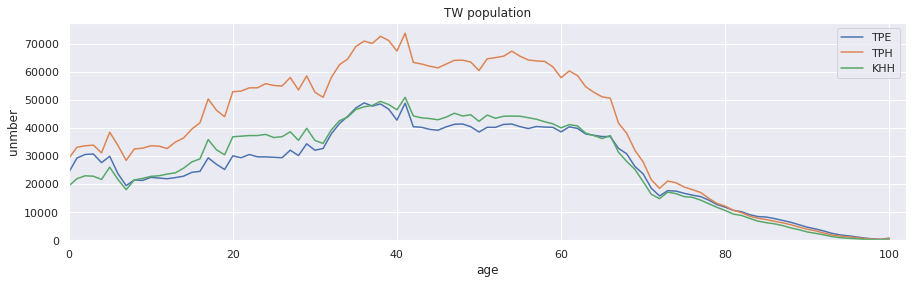

In [27]:
plt.figure(figsize=(15, 4))
plt.plot(city.values[13], label='TPE')
plt.plot(city.values[7], label='TPH')
plt.plot(city.values[21], label='KHH')
plt.title('TW population')
plt.xlim(0, 102)
plt.ylim(0,)
plt.ylabel('unmber')
plt.xlabel('age')
plt.legend()

### 人口差異大 調成百分比來比較:

In [28]:
ctysum = city.sum(axis=1)
city2 = ((city.T/ctysum)*100).T

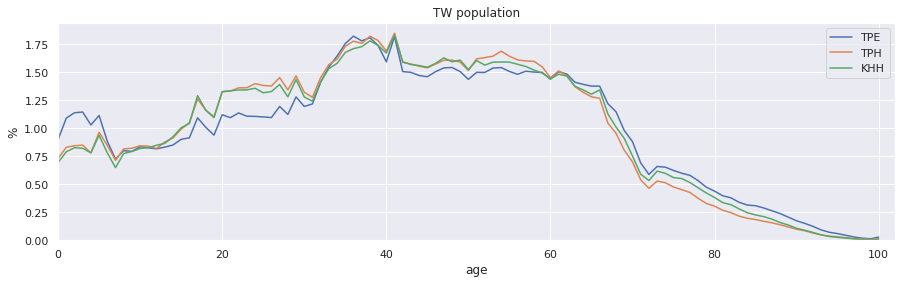

In [29]:
plt.figure(figsize=(15, 4))
plt.plot(city2.values[13], label='TPE')
plt.plot(city2.values[7], label='TPH')
plt.plot(city2.values[21], label='KHH')
plt.title('TW population')
plt.xlim(0, 102)
plt.ylim(0,)
plt.ylabel('%')
plt.xlabel('age')
plt.legend()

### 老齡化城市
65歲以上為老齡人口 表列出比例

In [30]:
city2[city2.columns[city2.columns>64]].sum(axis=1).sort_values().astype(str).str[0:5] + ' %'

縣市
連江縣    10.56 %
桃園市    10.78 %
臺中市    11.50 %
新竹市    11.50 %
新竹縣    11.98 %
金門縣    12.24 %
新北市    12.60 %
嘉義市    14.15 %
高雄市    14.21 %
臺南市    14.38 %
彰化縣    14.77 %
基隆市    14.81 %
花蓮縣    15.32 %
宜蘭縣    15.33 %
苗栗縣    15.41 %
澎湖縣    15.53 %
臺東縣    15.55 %
屏東縣    15.82 %
臺北市    16.36 %
南投縣    16.52 %
雲林縣    17.55 %
嘉義縣    18.46 %
dtype: object

### 老齡城市最嚴重 : 嘉義縣CHY  最輕微 : 連江縣LNN

### 老人鄉鎮區

In [31]:
con = pp.groupby(['鄉鎮區', '縣市']).sum()
consum = con.sum(axis=1)
con = ((con.T/consum)*100).T
conp = con[con.columns[con.columns>64]].sum(axis=1).sort_values().astype(str).str[0:5]
(conp.astype(str).str[0:5] + '%')
print(conp.head(3), conp.tail(3))

鄉鎮區   縣市 
那瑪夏區  高雄市    7.008
蘭嶼鄉   臺東縣    7.231
桃源區   高雄市    7.371
dtype: object 鄉鎮區  縣市 
左鎮區  臺南市    26.94
田寮區  高雄市    27.67
平溪區  新北市    28.37
dtype: object


### 老齡最嚴重平溪區(Pingxi)和最輕微那瑪夏區(Namaxia)比較

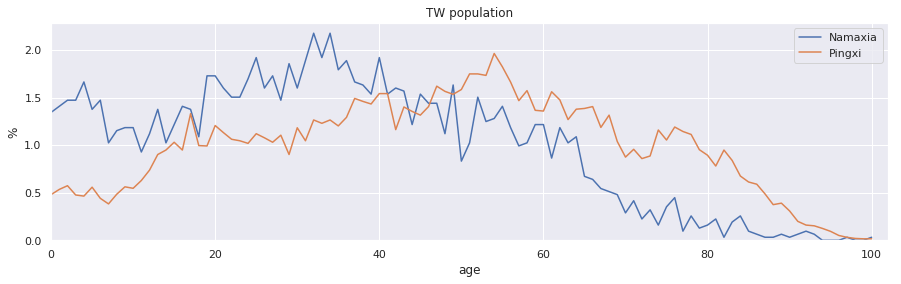

In [32]:
plt.figure(figsize=(15, 4))
plt.plot(con.loc[conp.index[0]], label='Namaxia')
plt.plot(con.loc[conp.index[358]], label='Pingxi')
plt.title('TW population')
plt.xlim(0, 102)
plt.ylim(0,)
plt.ylabel('%')
plt.xlabel('age')
plt.legend()

### 學齡兒童統計:
22個縣市 未上小學的兒童年齡0~6歲

In [33]:
city2[city2.columns[city2.columns<7]].sum(axis=1).sort_values().astype(str).str[0:5] + ' %'

縣市
嘉義縣    4.040 %
基隆市    4.535 %
屏東縣    4.649 %
南投縣    4.664 %
雲林縣    4.975 %
臺東縣    5.176 %
宜蘭縣    5.420 %
金門縣    5.457 %
澎湖縣    5.489 %
花蓮縣    5.505 %
高雄市    5.631 %
臺南市    5.833 %
新北市    5.848 %
嘉義市    5.934 %
苗栗縣    5.949 %
彰化縣    6.146 %
連江縣    6.824 %
臺中市    7.048 %
桃園市    7.298 %
臺北市    7.303 %
新竹縣    7.786 %
新竹市    8.282 %
dtype: object

### 最多兒童新竹市(HSC) 最少兒童嘉義市(CHY)

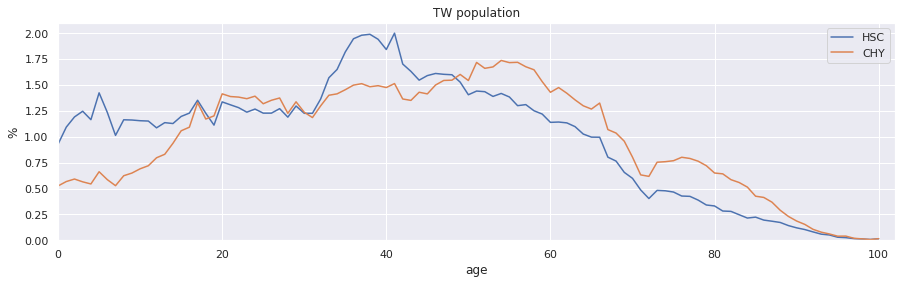

In [34]:
plt.figure(figsize=(15, 4))
plt.plot(city2.values[8], label='HSC')
plt.plot(city2.values[2], label='CHY')
plt.title('TW population')
plt.xlim(0, 102)
plt.ylim(0,)
plt.ylabel('%')
plt.xlabel('age')
plt.legend()

### 在學學生 年紀7~22歲

In [35]:
city2.iloc[:,7:23].sum(axis=1).sort_values().astype(str).str[0:5] + ' %'

縣市
連江縣    14.42 %
金門縣    14.67 %
臺北市    14.69 %
嘉義縣    15.81 %
臺南市    15.98 %
基隆市    16.09 %
高雄市    16.10 %
新北市    16.23 %
澎湖縣    16.25 %
屏東縣    16.40 %
南投縣    16.73 %
花蓮縣    16.80 %
雲林縣    16.98 %
臺東縣    17.06 %
宜蘭縣    17.07 %
苗栗縣    17.20 %
彰化縣    17.60 %
臺中市    18.23 %
桃園市    18.56 %
新竹市    19.03 %
嘉義市    19.13 %
新竹縣    19.29 %
dtype: object

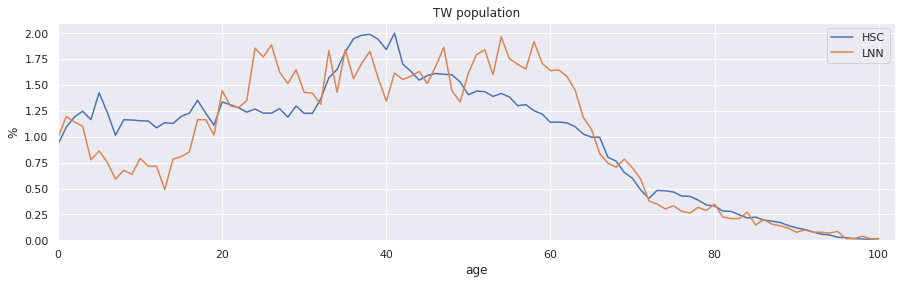

In [36]:
plt.figure(figsize=(15, 4))
plt.plot(city2.values[8], label='HSC')
plt.plot(city2.values[18], label='LNN')
plt.title('TW population')
plt.xlim(0, 102)
plt.ylim(0,)
plt.ylabel('%')
plt.xlabel('age')
plt.legend()

### 新竹市22年穩定輸出的出生率 新竹市竹科工作穩定應該有正相關 敢生小孩

# 3. 台灣犯罪圖解  資料日期: 104/01~107/03

### 讀入資料, 資料範例

In [37]:
crime = pd.read_csv('data/crime.csv')
crime.head()

,案類,發生日期,發生地點
0,住宅竊盜,1040101,台北市中山區
1,住宅竊盜,1040101,新北市永和區
2,住宅竊盜,1040101,台東縣台東市
3,住宅竊盜,1040101,台北市文山區
4,住宅竊盜,1040101,新北市三重區


### 資料筆數

In [38]:
crime.shape[0]

177801

## 資料處理：
### 將發生日期拆為   年  月  日

In [39]:
#crime['發生日期'] = crime['發生日期'].astype(str)
crime['year'] = (crime['發生日期']//10000) + 1911 #西元轉換
crime['month'] = ((crime['發生日期'] + 19110000) - (10000 * crime['year']))//100
crime['day'] = crime['發生日期'] + 19110000 - (10000 * crime['year']) - (100 * crime['month'])

#### 發現日期有 0 日  的錯誤資料

In [40]:
crime['day'].value_counts().sort_index().head()

0       9
1    7502
2    6217
3    6226
4    6415
Name: day, dtype: int64

#### 刪除錯誤的資料

In [41]:
crime = crime.query('day != 0')

### 將日期設為 DatetimeIndex ,  將發生地點拆為 縣市(city) 和 鄉鎮區(country)

In [42]:
crime.index = pd.to_datetime(10000 * crime.year + 100 * crime.month + crime.day, format='%Y%m%d')
crime = crime[['案類', '發生地點']]
crime.index.name = 'date'
crime['city'] = crime['發生地點'].str[0:3]
crime['country'] = crime['發生地點'].str[3:]
crime.head()

,案類,發生地點,city,country
date,,,,
2015-01-01,住宅竊盜,台北市中山區,台北市,中山區
2015-01-01,住宅竊盜,新北市永和區,新北市,永和區
2015-01-01,住宅竊盜,台東縣台東市,台東縣,台東市
2015-01-01,住宅竊盜,台北市文山區,台北市,文山區
2015-01-01,住宅竊盜,新北市三重區,新北市,三重區


#### 檢查空值, 刪去空值

In [43]:
display(crime['country'].isnull().any())
display(crime['country'].isnull().sum())
crime = crime[crime['country'].notnull()]

True

1

### 發現縣市出現了奇怪的'新竹鹿?', '台灣海?'

##### 刪除 新竹鹿, 外國, 台灣海 

In [44]:
crime['city'].value_counts().tail()

澎湖縣    230
連江縣     34
外國       5
台灣海      1
新竹鹿      1
Name: city, dtype: int64

In [45]:
crime = crime[crime['city'] != '新竹鹿']
crime = crime[crime['city'] != '台灣海']
crime = crime[crime['city'] != '外國']

### 將 縣市 案類  加入階層Index 並計數

In [46]:
crime.columns = ['kind', '發生地點', 'city', 'country']
crime = crime[['kind', 'city', 'country']]
crime['num'] = 1

In [47]:
crime.head()

,kind,city,country,num
date,,,,
2015-01-01,住宅竊盜,台北市,中山區,1
2015-01-01,住宅竊盜,新北市,永和區,1
2015-01-01,住宅竊盜,台東縣,台東市,1
2015-01-01,住宅竊盜,台北市,文山區,1
2015-01-01,住宅竊盜,新北市,三重區,1


### 資料整理完成 開始討論

## 案類比例

In [48]:
#ckind = crcount.pivot_table('num', index='kind', aggfunc='sum')
ckind = crime.groupby('kind').sum()
ckind = ckind/ckind.values.sum()*100
ckind.columns = ['percentage(%)']
ckind.sort_values(by='percentage(%)')

,percentage(%)
kind,
搶奪,0.511857
強盜,0.522544
強制性交,0.598479
住宅竊盜,4.796832
汽車竊盜,6.914008
機車竊盜,22.999820
毒品,63.656460


#### 毒品最大宗 約占了63.6%,  搶奪 強盜 強制性交 強迫他人的犯罪約在0.5 ~ 0.6% , 偷竊以機車竊盜最為嚴重 23%

## 案發地點討論

### 這裡要抓入台灣縣市人口數資料

In [49]:
place = crime.groupby('city').sum().reset_index()
pop = pd.read_csv('data/TW_pop.csv').sort_values(by='縣市')
pop.iloc[12:16,0] = '台' + pop.iloc[12:16,0].str[1:]
pop.columns = ['city', 'pop']
place = pd.merge(place, pop).set_index('city')
place = place.eval('time = 10000 * num / pop ').iloc[:,[2]]
place = place.sort_values(by='time')
place.columns=['time/10K People']
place

,time/10K People
city,
金門縣,18.551391
澎湖縣,22.099872
連江縣,26.397516
嘉義縣,43.213572
彰化縣,49.989941
台中市,55.660604
台東縣,57.757129
台南市,63.253967
台北市,63.355840


## 細部案類討論

In [50]:
pcek = crime.pivot_table('num', index='city', columns='kind', aggfunc='sum', margins=True, fill_value=0).reset_index()
pcek = pd.merge(pcek, pop).set_index('city')
pcek = (10000 * pcek.T / pcek['pop']).T
pcek = pcek.iloc[:,0:8]
pcek

,住宅竊盜,強制性交,強盜,搶奪,機車竊盜,毒品,汽車竊盜,All
city,,,,,,,,
南投縣,7.125023,0.918070,0.638658,0.379203,18.022118,48.198686,6.765778,82.047536
台中市,1.628951,0.315744,0.261924,0.287040,13.957310,35.869210,3.340426,55.660604
台北市,4.964116,0.674553,0.290691,0.327960,8.515770,47.501972,1.080776,63.355840
台南市,5.905046,0.811016,0.530076,0.455865,16.024197,33.855953,5.671813,63.253967
台東縣,2.004191,0.045550,0.136649,0.091100,15.623577,38.762868,1.093195,57.757129
嘉義市,2.227188,1.670391,0.371198,0.185599,11.173060,58.612165,7.683799,81.923400
嘉義縣,1.506313,0.899875,0.234750,0.215188,6.436064,28.698194,5.223189,43.213572
基隆市,6.353343,1.426810,0.942233,0.565340,17.713981,107.683776,2.207517,136.893000
宜蘭縣,5.891281,0.766524,0.569417,0.197106,12.089171,49.692624,6.175989,75.382112


## 案類分類排名:
### 外島(澎湖 金門 馬祖)汽機車失竊特別低, 但在住宅竊盜不輸本島, 汽機車竊盜罪嚴重在桃園新竹一帶, 基隆市毒品格外嚴重

for n in range(7):
    print(pcek.columns[n])
    display(pd.DataFrame((pcek.iloc[:,n]).sort_values(ascending=False)))
    print('')

## 犯罪的周末?
#### 星期幾與犯罪數的關係

Text(0.5, 0, 'dayofweek')

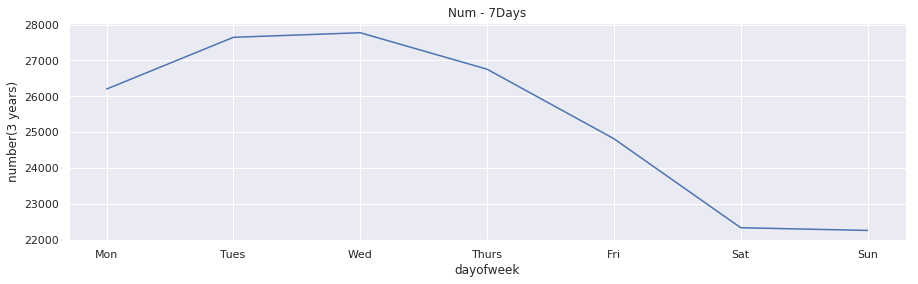

In [51]:
cweek = crime.groupby(crime.index.dayofweek).sum()
cweek.index = [i for i in range(1, 8)]
cweek.index.name = 'dayofweek'
cweek.columns = ['time']
plt.figure(figsize=(15, 4))
plt.plot(cweek)
plt.title('Num - 7Days')
plt.gca().set_xticklabels(['', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('number(3 years)')
plt.xlabel('dayofweek')

In [52]:
print('周末與平日的案件比例 : %.03f'%(cweek.values[5:].mean()/cweek.values[0:5].mean()))

周末與平日的案件比例 : 0.837



### 周末案件數約平日的80％  周休二日還沒確切落實在罪犯和警察身上
### 接著細部探究犯案種類和星期幾的關係

,weekend/weekday(%)
kind,
毒品,77.375236
汽車竊盜,87.099605
搶奪,90.059791
強盜,91.042584
住宅竊盜,93.926440
機車竊盜,97.822389
強制性交,123.071529


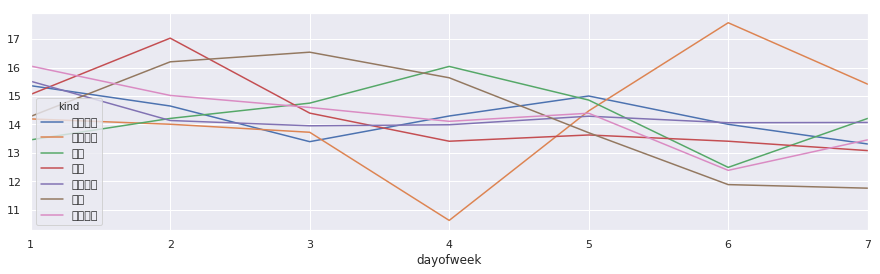

In [53]:
ckweek = crime.pivot_table('num', index=crime.index.dayofweek, columns='kind', aggfunc='sum')
ckweek.index = [1,2,3,4,5,6,7]
ckweek.index.name = 'dayofweek'
ckweek = ckweek/ckweek.sum()*100
ckweek.plot(figsize=(15, 4))
ckweek = pd.DataFrame((100 * ckweek[ckweek.index>5].mean()/ckweek[ckweek.index<6].mean()).sort_values())
ckweek.columns = ['weekend/weekday(%)']
ckweek

### 強制性交在假日有明顯提高, 毒品在假日比較少(寂寞的時候才要吸毒), 機車竊盜假日平日並無不同

## 犯罪會跟日期365天有關嗎?
### 看圖似乎有四季變化 圖形震盪就是顯示平日和假日一周變化

<function matplotlib.pyplot.legend(*args, **kwargs)>

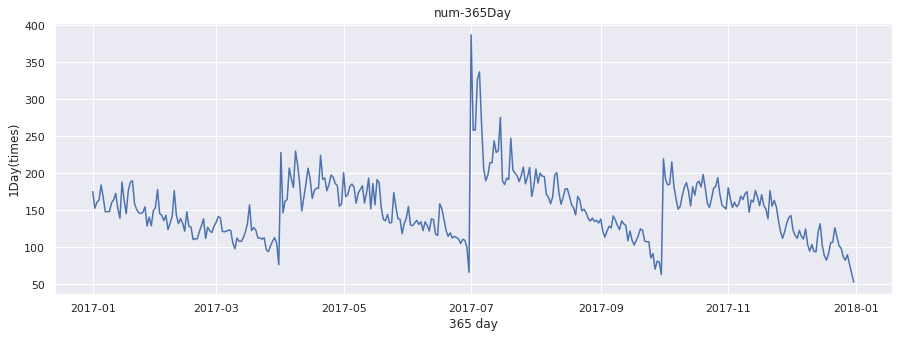

In [54]:
crcount = crime.groupby([crime.index.year, crime.index.month, crime.index.day, 'city', 'kind']).sum()
crcount.index.names = ['year', 'month', 'day', 'city', 'kind']
cday = crcount.groupby(['year', 'month', 'day']).sum()
cday = cday.groupby(['month', 'day']).mean()
cday = cday.loc[(1, 1):(2, 28)].append(cday.loc[(3, 1):(12, 31)]) #除去(2/29)資料
cday.index = [pd.datetime(2017, month, day) for (month, day) in cday.index]
plt.figure(figsize=(15, 5))
plt.plot(cday)
plt.title('num-365Day')
plt.ylabel('1Day(times)')
plt.xlabel('365 day')
plt.legend

### 畫上2周均線 讓線圖更柔化  並將y軸歸零
#### 並透過高斯窗口 Cosine window 讓圖形看起來平滑

<function matplotlib.pyplot.legend(*args, **kwargs)>

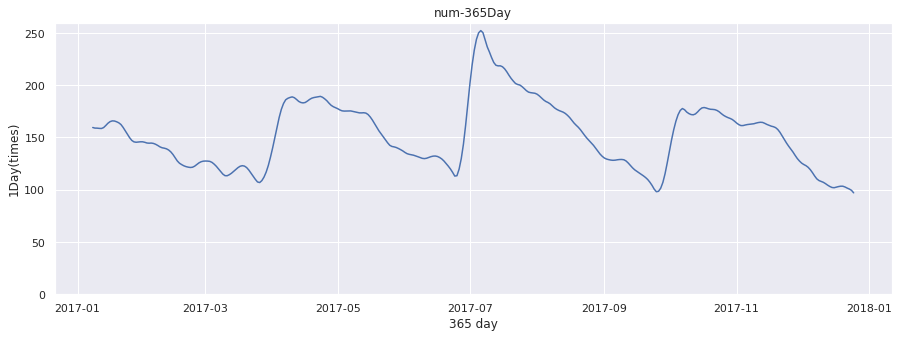

In [55]:
rolling = cday.rolling(14, center=True, win_type='cosine')
data = rolling.mean()
plt.figure(figsize=(15, 5))
plt.plot(data)
plt.title('num-365Day')
plt.ylabel('1Day(times)')
plt.ylim(0,)
plt.xlabel('365 day')
plt.legend